In [1]:
import sys
sys.path.insert(0,'/home/richard.brito/pSEOBNRv4HM/opt/lib64/python2.7/site-packages/')

In [2]:
import os
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import sys
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner
import imrtgrutils_final as tgr
import argparse
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde

%matplotlib inline 

In [3]:
######################

# Generating the triangle plot

######################

def triangle_plot_2d_axes(
    xbounds, ybounds, figsize=(8, 8),
    width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.0, hspace=0.0,
    grid=False,high1d=1):
    """Initialize the axes for a 2d triangle plot.
    """
    high1d = high1d

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(
        2, 2,
        width_ratios=width_ratios, height_ratios=height_ratios,
        wspace=wspace, hspace=hspace)

    ax1 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])

    ax1.minorticks_on()
    ax3.minorticks_on()
    ax4.minorticks_on()

    if grid:
        ax1.grid(which='major', ls='-')
        ax1.grid(which='minor', ls=':')
        ax3.grid(which='major', ls='-')
        ax3.grid(which='minor', ls=':')
        ax4.grid(which='major', ls='-')
        ax4.grid(which='minor', ls=':')

    # Get rid of tick labels
    ax1.xaxis.set_ticklabels([])
    ax4.yaxis.set_ticklabels([])

    # Use consistent x-axis and y-axis bounds in all 3 plots
    ax1.set_ylim(0, high1d)
    ax1.set_xlim(xbounds[0], xbounds[1])
    ax3.set_xlim(xbounds[0], xbounds[1])
    ax3.set_ylim(ybounds[0], ybounds[1])
    ax4.set_xlim(0, high1d)
    ax4.set_ylim(ybounds[0], ybounds[1])

    return fig, ax1, ax3, ax4



######################

# Bounded KDE function from Ben Farr's original script in LAL

######################


#cp = sns.color_palette('colorblind', 6)
#plt.style.use("MATPLOTLIB_RCPARAMS.sty")


import numpy as np
from scipy.special import erf
from scipy.stats import gaussian_kde

class Bounded_kde(gaussian_kde):
    r"""Represents a one-dimensional Gaussian kernel density estimator
    for a probability distribution function that exists on a bounded
    domain."""

    def __init__(self, pts, low=None, high=None, *args, **kwargs):
        """Initialize with the given bounds.  Either ``low`` or
        ``high`` may be ``None`` if the bounds are one-sided.  Extra
        parameters are passed to :class:`gaussian_kde`.

        :param low: The lower domain boundary.

        :param high: The upper domain boundary."""
        pts = np.atleast_1d(pts)

        assert pts.ndim == 1, 'Bounded_kde can only be one-dimensional'
        
        super(Bounded_kde, self).__init__(pts, *args, **kwargs)

        self._low = low
        self._high = high

    @property
    def low(self):
        """The lower bound of the domain."""
        return self._low

    @property
    def high(self):
        """The upper bound of the domain."""
        return self._high

    def evaluate(self, xs):
        """Return an estimate of the density evaluated at the given
        points."""
        xs = np.atleast_1d(xs)
        assert xs.ndim == 1, 'points must be one-dimensional'

        pdf = super(Bounded_kde, self).evaluate(xs)

        if self.low is not None:
            pdf += super(Bounded_kde, self).evaluate(2.0*self.low - xs)

        if self.high is not None:
            pdf += super(Bounded_kde, self).evaluate(2.0*self.high - xs)

        return pdf

    __call__ = evaluate


######################

# Function to create axes

######################

def create_fig_and_axes(xbounds, ybounds, figsize=(9.7, 9.7),high1d=1):
    fig, ax1, ax3, ax4 = triangle_plot_2d_axes(
        xbounds, ybounds, figsize=figsize, width_ratios=[4, 1],
        height_ratios=[1, 4], wspace=0.0, hspace=0.0,high1d=high1d)
    return fig, ax1, ax3, ax4


######################

# Function to add PE posteriors to the figure

######################

def add_samples_to_fig(name,samples_x, samples_y,zorder=10,norm_factor_x=1,norm_factor_y=1,bounded=False,plot_density=True):
    
    #name: name of samples to plot
    #samples_x and samples_y: samples to plot in the 2D plot
    #zorder: if plottting multiple results, a larger zorder places the contour on top
    #norm_factor_x,y: parameter to scale the corner 1D histograms
    
    x = samples_x
    y = samples_y
    xlow, xhigh = xlims
    xsmooth = np.linspace(xlow, xhigh, 1000)
    ylow, yhigh = ylims
    ysmooth = np.linspace(ylow, yhigh, 1000)

    norm_factor_x=0.95*norm_factor_x
    norm_factor_y=0.95*norm_factor_y
    
    c = color_dict[name]
    label = label_dict[name]
    alpha = alpha_dict[name]
    lw = 2
    ls = ls_dict[name]
    
    
    if bounded==True:
        
        print("Using bounded KDE")
    
        kde = Bounded_kde(x)
    
    else: 
        
        kde = gaussian_kde(x)
    
    
    
    ax1.plot(xsmooth, norm_factor_x*kde(xsmooth), color=c, lw=lw, label=label,
             zorder=zorder,linestyle=ls)
    ax1.fill_between(xsmooth, 0, norm_factor_x*kde(xsmooth), color=c, alpha=alpha,
                     zorder=zorder)
    #ax1.axis('off')
    #ax1.axvline(np.quantile(x, 0.05), color=c,ls=ls)
    #ax1.axvline(np.quantile(x, 0.95), color=c,ls=ls)

    kde = gaussian_kde(y)
    
    ax4.plot(norm_factor_y*kde(ysmooth), ysmooth, color=c, lw=lw, label=label,
             zorder=zorder,linestyle=ls)

    ax4.fill_betweenx(ysmooth, 0, norm_factor_y*kde(ysmooth), color=c, alpha=alpha,
                      zorder=zorder)
    #ax4.axhline(np.quantile(y, 0.05), color=c)
    #ax4.axhline(np.quantile(y, 0.95), color=c)
    
    #the level=0.9 parameter, makes the 2D contours enclose the 90% of the posterior volume/surface.

    my_range = [[xlow, xhigh], [ylow, yhigh]]
    corner.hist2d(x, y, ax=ax3, range=my_range, color=c,
                  plot_datapoints=False, plot_density=plot_density,smooth=True,
                  levels=[0.9],fill_contours=False,bins=50,contour_kwargs={'linestyles':ls})

In [4]:
def inj_fvstau(data,lm,prec=True):
   
    m1, m2, a1x, a1y, a1z, a2x, a2y, a2z = data
    
    if prec==False:
        omega_inj, tau_inj = calcqnm.get_sigmalm0SI_GR(np.array([m1]), np.array([m2]), 
                                                       np.array([a1z]), np.array([a2z]), lm)
        freq_inj = omega_inj/(2.*np.pi)
    else:
        omega_inj, tau_inj = calcqnm.get_sigmalm0SI_GR_prec(np.array([m1]), np.array([m2]), 
                                                            np.array([a1x]), np.array([a1y]),np.array([a1z]), 
                                                            np.array([a2x]), np.array([a2y]),np.array([a2z]),
                                                            lm)
        freq_inj = omega_inj/(2.*np.pi)
    
    return freq_inj, tau_inj


def samples_fvstau(data,freq_inj,tau_inj,lm):

    if ('mf_evol' in data.dtype.names) and ('af_evol' in data.dtype.names):
        mf, af, m1, m2, a1z, a2z, domega, dtau = data['mf_evol'], data['af_evol'], data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
    elif ('mf' in data.dtype.names) and ('af' in data.dtype.names):
        mf, af, m1, m2, a1z, a2z, domega, dtau = data['mf'], data['af'], data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']
    else:
        m1, m2, a1, a2, a1z, a2z, domega, dtau = data['mass_1'], data['mass_2'], data['a_1'], data['a_2'], data['chi_1'], data['chi_2'], data['domega220'], data['dtau220']
        tilt1, tilt2, phi12 = np.zeros(len(m1)), np.zeros(len(m1)), np.zeros(len(m1))
        mf, af = tgr.calc_final_mass_spin(m1, m2, a1, a2, a1z, a2z, tilt1, tilt2, phi12, 'bbh_average_fits_precessing')

    # create (omega, tau) GR and modGRarrays
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)

    Deltaf=freq_modGR-freq_inj
    Deltatau=1000*(tau_modGR-tau_inj)

    return Deltaf, Deltatau
    

# SEOBNRv4HM and SEOBNRv4PHM software injections for S190521g-like BBHs 

https://git.ligo.org/cbc-testinggr/reviews/nohairtesteobhm/-/wikis/S190521g#software-injections

In [5]:
SWINJ2 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_pSEOBNRv4HM_SEOBNRv4HMinj/pesummary/samples/S190521g_pSEOBNRv4HM_SEOBNRv4HMinj_pesummary.dat'
                     , names=True, dtype=None)
#SWINJ4 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_pSEOBNRv4HM_SEOBNRv4PHMinj/pesummary/samples/S190521g_pSEOBNRv4HM_SEOBNRv4PHMinj_pesummary.dat', names=True, dtype=None)

SWINJ11 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_pSEOBNRv4HM_SEOBNRv4PHMinj_dtaumin_m0p8/pesummary/samples/S190521g_pSEOBNRv4HM_SEOBNRv4PHMinj_dtaumin_m0p8_pesummary.dat'
                     , names=True, dtype=None)

SWINJ6 = np.genfromtxt('/home/richard.brito/public_html/spinqnm/runs_data/software_injections/S190521g/SEOBNRv4HM/220/posterior_samples.dat'
                     , names=True, dtype=None)
SWINJ8 = np.genfromtxt('/home/richard.brito/public_html/spinqnm/runs_data/software_injections/S190521g/SEOBNRv4PHM/220/posterior_samples.dat'
                     , names=True, dtype=None)
SWINJ10 = np.genfromtxt('/home/richard.brito/public_html/spinqnm/runs_data/software_injections/S190521g/SEOBNRv4PHM/220_zeronoise/posterior_samples.dat'
                     , names=True, dtype=None)

PROD2 = np.genfromtxt('/home/richard.brito/public_html/spinqnm/runs_data/S190521g/220/posterior_samples.dat'
                     , names=True, dtype=None)

In [6]:
!ligolw_print -c mass1 -c mass2 -c spin1x -c spin1y -c spin1z -c spin2x -c spin2y -c spin2z  /home/richard.brito/public_html/spinqnm/runs_data/software_injections/S190521g/SEOBNRv4HM/hwinjcbc_1242442957.xml
!ligolw_print -c mass1 -c mass2 -c spin1x -c spin1y -c spin1z -c spin2x -c spin2y -c spin2z  /home/richard.brito/public_html/spinqnm/runs_data/software_injections/S190521g/SEOBNRv4PHM/hwinjcbc_1242442957.xml
!ligolw_print -c mass1 -c mass2 -c spin1x -c spin1y -c spin1z -c spin2x -c spin2y -c spin2z  /home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_pSEOBNRv4HM_SEOBNRv4PHMinj/raw_data/hwinjcbc_1242442957.xml

214.57917,107.28958,0,0,0.6,0,0,0.2
198.59469,99.297345,0.6,-0.2,0.1,0.3,0,0.3
198.59469,99.297345,0.6,-0.2,0.1,0.3,0,0.3


In [7]:
inj_SEOB_bilby=[193.213626819,96.6068134095,0,0,-0.171452322533,0,0,-0.0881284619252]
inj_SEOB_LI=[214.57917,107.28958,0,0,0.6,0,0,0.2]
inj_SEOBP=[198.59469,99.297345,0.6,-0.2,0.1,0.3,0,0.3]

In [8]:
lm = [2,2]

freq_inj0,tau_inj0=inj_fvstau(inj_SEOB_bilby,lm)
Deltaf_SWINJ2,Deltatau_SWINJ2=samples_fvstau(SWINJ2,freq_inj0,tau_inj0,lm)

#freq_inj0,tau_inj0=inj_fvstau(inj_SEOBP,lm)
#Deltaf_SWINJ4,Deltatau_SWINJ4=samples_fvstau(SWINJ4,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0=inj_fvstau(inj_SEOBP,lm)
Deltaf_SWINJ11,Deltatau_SWINJ11=samples_fvstau(SWINJ11,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0=inj_fvstau(inj_SEOB_LI,lm)
Deltaf_SWINJ6,Deltatau_SWINJ6=samples_fvstau(SWINJ6,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0==inj_fvstau(inj_SEOBP,lm)
Deltaf_SWINJ8,Deltatau_SWINJ8=samples_fvstau(SWINJ8,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0==inj_fvstau(inj_SEOBP,lm)
Deltaf_SWINJ10,Deltatau_SWINJ10=samples_fvstau(SWINJ10,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0==inj_fvstau(inj_SEOBP,lm)
Deltaf_21g,Deltatau_21g=samples_fvstau(PROD2,freq_inj0,tau_inj0,lm)

## pbilby results

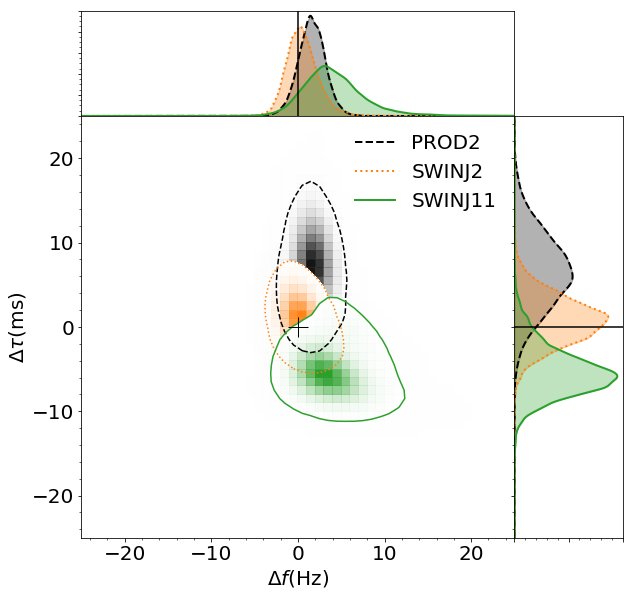

In [9]:
color_dict = dict(INJ1="C1",INJ2="C2",PROD="black")
label_dict = dict(INJ1="SWINJ2",INJ2="SWINJ11",PROD="PROD2")
ls_dict = dict(INJ1="dotted",INJ2="solid",PROD="dashed")
alpha_dict = dict(INJ1=0.3,INJ2=0.3,INJ3=0.3,INJ4=0.3,INJ5=0.3,INJ6=0.3,PROD=0.3)

xlims = [-25, 25]
ylims = [-25, 25]

norm_factor = 1.60

fig, ax1, ax3, ax4 = create_fig_and_axes(xlims, ylims)
ax3.set_xlabel(r"$\Delta f (\rm{Hz})$",fontsize=20)
ax3.set_ylabel(r"$\Delta \tau (\rm{ms})$",fontsize=20)
ax3.tick_params(labelsize=10)

my_array_x=np.linspace(xlims[0],xlims[1],1000)
my_array_y=np.linspace(ylims[0],ylims[1],1000)

r1x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ2)(my_array_x))
r2x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ11)(my_array_x))
r3x=1/np.max(scipy.stats.gaussian_kde(Deltaf_21g)(my_array_x))

r1y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ2)(my_array_y))
r2y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ11)(my_array_y))
r3y=1/np.max(scipy.stats.gaussian_kde(Deltatau_21g)(my_array_x))

norm_factor_x = np.min([r1x,r2x,r3x])
norm_factor_y = np.min([r1y,r2y,r3y])

add_samples_to_fig("PROD",Deltaf_21g,Deltatau_21g,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ1",Deltaf_SWINJ2,Deltatau_SWINJ2,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ2",Deltaf_SWINJ11,Deltatau_SWINJ11,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)

ax3.set_xlim(*xlims)
ax1.set_yticklabels([],fontsize=10)

ax4.set_xticklabels([],fontsize=20)

ax3.tick_params(axis='both', labelsize=20)

ax3.plot([0], '+', c='black',markersize=20)

ax3.legend(*ax4.get_legend_handles_labels(), loc=1, frameon=False,prop={'size': 20})

ax1.axvline(x=0,c='black')
ax4.axhline(y=0,c='black')

plt.show()

## lalinference results

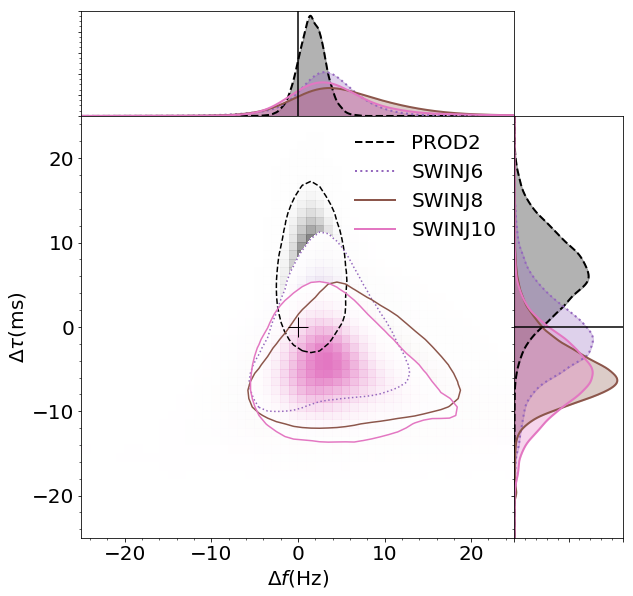

In [10]:
color_dict = dict(INJ4="C4",INJ5="C5",INJ6="C6",PROD="black")
label_dict = dict(INJ4="SWINJ6",INJ5="SWINJ8",INJ6="SWINJ10",PROD="PROD2")
ls_dict = dict(INJ4="dotted",INJ5="-",INJ6="-",PROD="dashed")
alpha_dict = dict(INJ4=0.3,INJ5=0.3,INJ6=0.3,PROD=0.3)

xlims = [-25, 25]
ylims = [-25, 25]

norm_factor = 1.60

fig, ax1, ax3, ax4 = create_fig_and_axes(xlims, ylims)
ax3.set_xlabel(r"$\Delta f (\rm{Hz})$",fontsize=20)
ax3.set_ylabel(r"$\Delta \tau (\rm{ms})$",fontsize=20)
ax3.tick_params(labelsize=10)

my_array_x=np.linspace(xlims[0],xlims[1],1000)
my_array_y=np.linspace(ylims[0],ylims[1],1000)

r3x=1/np.max(scipy.stats.gaussian_kde(Deltaf_21g)(my_array_x))
r4x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ6)(my_array_x))
r5x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ8)(my_array_x))
r6x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ10)(my_array_x))

r3y=1/np.max(scipy.stats.gaussian_kde(Deltatau_21g)(my_array_x))
r4y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ6)(my_array_y))
r5y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ8)(my_array_y))
r6y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ10)(my_array_y))


norm_factor_x = np.min([r3x,r4x,r5x,r6x])
norm_factor_y = np.min([r3y,r4y,r5y,r6y])

add_samples_to_fig("PROD",Deltaf_21g,Deltatau_21g,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ4",Deltaf_SWINJ6,Deltatau_SWINJ6,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ5",Deltaf_SWINJ8,Deltatau_SWINJ8,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ6",Deltaf_SWINJ10,Deltatau_SWINJ10,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)

ax3.set_xlim(*xlims)
ax1.set_yticklabels([],fontsize=10)

ax4.set_xticklabels([],fontsize=20)

ax3.tick_params(axis='both', labelsize=20)

ax3.plot([0], '+', c='black',markersize=20)

ax3.legend(*ax4.get_legend_handles_labels(), loc=1, frameon=False,prop={'size': 20})

ax1.axvline(x=0,c='black')
ax4.axhline(y=0,c='black')

plt.show()

# Noise injections for a S190521g-like BBH with NRSur7dq4 

https://git.ligo.org/cbc-testinggr/reviews/nohairtesteobhm/-/wikis/S190521g_noisesystematics

In [11]:
SWINJ7 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_zeronoise/pesummary/samples/S190521g_NRSurEXP30inj_pSEOBNRv4HM_zeronoise_pesummary.dat'
                     , names=True, dtype=None)
SWINJ8 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise01/pesummary/samples/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise01_pesummary.dat'
                     , names=True, dtype=None)

SWINJ9 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise02/pesummary/samples/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise02_pesummary.dat'
                     , names=True, dtype=None)

SWINJ10 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise03/pesummary/samples/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise03_pesummary.dat'
                     , names=True, dtype=None)
SWINJ11 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise04/pesummary/samples/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise04_pesummary.dat'
                     , names=True, dtype=None)
SWINJ12 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise05/pesummary/samples/S190521g_NRSurEXP30inj_pSEOBNRv4HM_noise05_pesummary.dat'
                     , names=True, dtype=None)

PROD2 = np.genfromtxt('/home/richard.brito/public_html/spinqnm/runs_data/S190521g/220/posterior_samples.dat'
                     , names=True, dtype=None)

In [12]:
inj_NRsur=[152.59922,120.40078,-0.002648142,0.020819712,-0.02299293,0.83239804,0.0033048995,0.3864437]

In [13]:
lm = [2,2]

freq_inj0,tau_inj0=inj_fvstau(inj_NRsur,lm)
Deltaf_SWINJ7,Deltatau_SWINJ7=samples_fvstau(SWINJ7,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0=inj_fvstau(inj_NRsur,lm)
Deltaf_SWINJ8,Deltatau_SWINJ8=samples_fvstau(SWINJ8,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0=inj_fvstau(inj_NRsur,lm)
Deltaf_SWINJ9,Deltatau_SWINJ9=samples_fvstau(SWINJ9,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0=inj_fvstau(inj_NRsur,lm)
Deltaf_SWINJ10,Deltatau_SWINJ10=samples_fvstau(SWINJ10,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0==inj_fvstau(inj_NRsur,lm)
Deltaf_SWINJ11,Deltatau_SWINJ11=samples_fvstau(SWINJ11,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0==inj_fvstau(inj_NRsur,lm)
Deltaf_SWINJ12,Deltatau_SWINJ12=samples_fvstau(SWINJ12,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0==inj_fvstau(inj_NRsur,lm)
Deltaf_21g,Deltatau_21g=samples_fvstau(PROD2,freq_inj0,tau_inj0,lm)

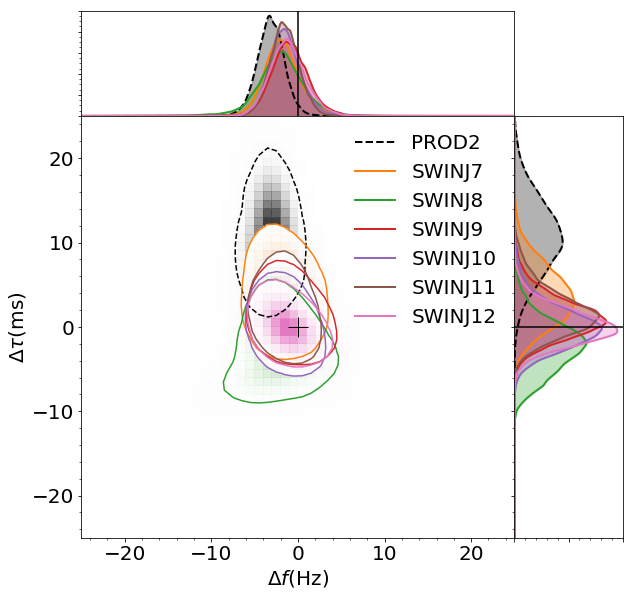

In [14]:
color_dict = dict(PROD='black',INJ1="C1",INJ2="C2",INJ3="C3",INJ4="C4",INJ5="C5",INJ6="C6")
label_dict = dict(PROD="PROD2",INJ1="SWINJ7",INJ2="SWINJ8",INJ3="SWINJ9",INJ4="SWINJ10",INJ5="SWINJ11",INJ6="SWINJ12")
ls_dict = dict(PROD="--",INJ1="-",INJ2="-",INJ3="-",INJ4="-",INJ5="-",INJ6="-")
alpha_dict = dict(PROD=0.3,INJ1=0.3,INJ2=0.3,INJ3=0.3,INJ4=0.3,INJ5=0.3,INJ6=0.3)

xlims = [-25, 25]
ylims = [-25, 25]

norm_factor = 1.60

fig, ax1, ax3, ax4 = create_fig_and_axes(xlims, ylims)
ax3.set_xlabel(r"$\Delta f (\rm{Hz})$",fontsize=20)
ax3.set_ylabel(r"$\Delta \tau (\rm{ms})$",fontsize=20)
ax3.tick_params(labelsize=10)

my_array_x=np.linspace(xlims[0],xlims[1],1000)
my_array_y=np.linspace(ylims[0],ylims[1],1000)

r1x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ7)(my_array_x))
r2x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ8)(my_array_x))
r3x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ9)(my_array_x))
r4x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ10)(my_array_x))
r5x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ11)(my_array_x))
r6x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ12)(my_array_x))
r7x=1/np.max(scipy.stats.gaussian_kde(Deltaf_21g)(my_array_x))

r1y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ7)(my_array_y))
r2y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ8)(my_array_y))
r3y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ9)(my_array_y))
r4y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ10)(my_array_y))
r5y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ11)(my_array_y))
r6y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ12)(my_array_y))
r7y=1/np.max(scipy.stats.gaussian_kde(Deltatau_21g)(my_array_y))


norm_factor_x = np.min([r1x,r2x,r3x,r4x,r5x,r6x,r7x])
norm_factor_y = np.min([r1y,r2y,r3y,r4y,r5y,r6y,r7y])

add_samples_to_fig("PROD",Deltaf_21g,Deltatau_21g,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ1",Deltaf_SWINJ7,Deltatau_SWINJ7,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ2",Deltaf_SWINJ8,Deltatau_SWINJ8,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ3",Deltaf_SWINJ9,Deltatau_SWINJ9,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ4",Deltaf_SWINJ10,Deltatau_SWINJ10,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ5",Deltaf_SWINJ11,Deltatau_SWINJ11,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ6",Deltaf_SWINJ12,Deltatau_SWINJ12,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)

ax3.set_xlim(*xlims)
ax1.set_yticklabels([],fontsize=10)

ax4.set_xticklabels([],fontsize=20)

ax3.tick_params(axis='both', labelsize=20)

ax3.plot([0], '+', c='black',markersize=20)

ax3.legend(*ax4.get_legend_handles_labels(), loc=1, frameon=False,prop={'size': 20})

ax1.axvline(x=0,c='black')
ax4.axhline(y=0,c='black')

plt.show()

# SEOBNRv4HM software injection (SNR~25) on gaussian noise for GW150914-like BBH 

https://git.ligo.org/cbc-testinggr/reviews/nohairtesteobhm/-/wikis/GW150914#software-injections

In [15]:
SWINJ2 = np.genfromtxt('/home/richard.brito/public_html/spinqnm/runs_data/software_injections/GW150914/220/posterior_samples.dat', names=True, dtype=None)

In [16]:
inj_SEOB=[38.528615,33.400535,0,0,0.0034699018,0,0,-0.044004041]
inj_SXS0007=[42,28,0,0,0.0,0,0,0.0]

In [17]:
lm = [2,2]

freq_inj0,tau_inj0=inj_fvstau(inj_SEOB,lm)
Deltaf_SWINJ2,Deltatau_SWINJ2=samples_fvstau(SWINJ2,freq_inj0,tau_inj0,lm)

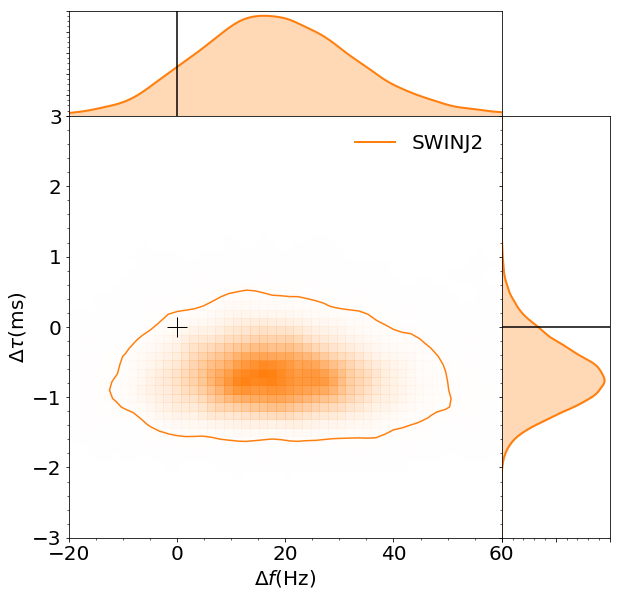

In [18]:
color_dict = dict(PROD='black',INJ1="C1",INJ2="C2")
label_dict = dict(PROD='PROD2',INJ1="SWINJ2",INJ2="NRINJ1")
ls_dict = dict(PROD="--",INJ1="-",INJ2="-")
alpha_dict = dict(PROD=0.3,INJ1=0.3,INJ2=0.3)

xlims = [-20, 60]
ylims = [-3, 3]

norm_factor = 1.60

fig, ax1, ax3, ax4 = create_fig_and_axes(xlims, ylims)
ax3.set_xlabel(r"$\Delta f (\rm{Hz})$",fontsize=20)
ax3.set_ylabel(r"$\Delta \tau (\rm{ms})$",fontsize=20)
ax3.tick_params(labelsize=10)

my_array_x=np.linspace(xlims[0],xlims[1],1000)
my_array_y=np.linspace(ylims[0],ylims[1],1000)

r1x=1/np.max(scipy.stats.gaussian_kde(Deltaf_SWINJ2)(my_array_x))

r1y=1/np.max(scipy.stats.gaussian_kde(Deltatau_SWINJ2)(my_array_y))

norm_factor_x = np.min([r1x])
norm_factor_y = np.min([r1y])

add_samples_to_fig("INJ1",Deltaf_SWINJ2,Deltatau_SWINJ2,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)

ax3.set_xlim(*xlims)
ax1.set_yticklabels([],fontsize=10)

ax4.set_xticklabels([],fontsize=20)

ax3.tick_params(axis='both', labelsize=20)

ax3.plot([0], '+', c='black',markersize=20)

ax3.legend(*ax4.get_legend_handles_labels(), loc=1, frameon=False,prop={'size': 20})

ax1.axvline(x=0,c='black')
ax4.axhline(y=0,c='black')

plt.show()

# NR zero-injections for q=1.5 BBH (Mtotal=70, SNR ~ 50) and a q=6 BBH (Mtotal=84, SNR ~ 70) 

https://git.ligo.org/cbc-testinggr/reviews/nohairtesteobhm/-/wikis/GW150914#software-injections

In [19]:
NRINJ1 = np.genfromtxt('/home/richard.brito/public_html/spinqnm/runs_data/software_injections/GW150914/220_SXS0007/posterior_samples.dat', names=True, dtype=None)

NRINJ3 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/GW150914_SXS_BBH_0007/pesummary/samples/GW150914_SXS_BBH_0007_pesummary.dat', names=True, dtype=None)
NRINJ4 = np.genfromtxt('/home/abhirup.ghosh/public_html/spinqnm/runs/parallel_bilby/GW150914_SXS_BBH_0166/pesummary/samples/GW150914_SXS_BBH_0166_pesummary.dat', names=True, dtype=None)




In [20]:
inj_SXS0007=[42,28,0,0,0.0,0,0,0.0]
inj_SXS0166=[72,12,0,0,0.0,0,0,0.0]

In [21]:
freq_inj0,tau_inj0=inj_fvstau(inj_SXS0007,lm)
Deltaf_NRINJ1,Deltatau_NRINJ1=samples_fvstau(NRINJ1,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0=inj_fvstau(inj_SXS0007,lm)
Deltaf_NRINJ3,Deltatau_NRINJ3=samples_fvstau(NRINJ3,freq_inj0,tau_inj0,lm)

freq_inj0,tau_inj0=inj_fvstau(inj_SXS0166,lm)
Deltaf_NRINJ4,Deltatau_NRINJ4=samples_fvstau(NRINJ4,freq_inj0,tau_inj0,lm)


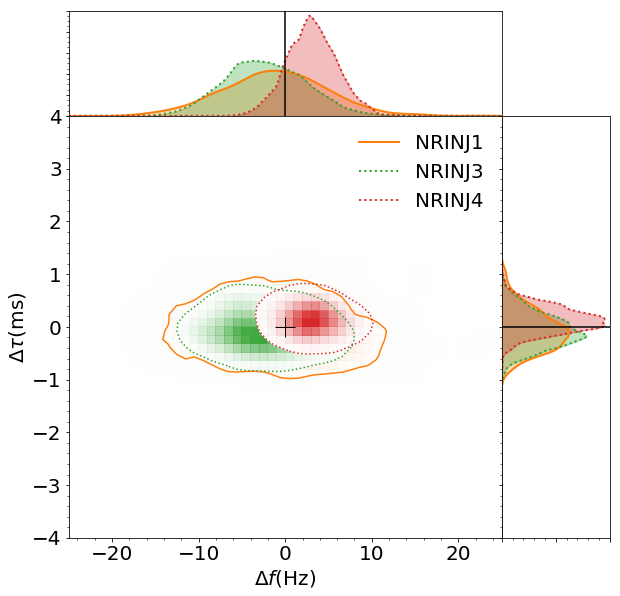

In [22]:
color_dict = dict(INJ1="C1",INJ2="C2",INJ3="C3")
label_dict = dict(INJ1="NRINJ1",INJ2="NRINJ3",INJ3="NRINJ4")
ls_dict = dict(INJ1="-",INJ2="dotted",INJ3="dotted")
alpha_dict = dict(INJ1=0.3,INJ2=0.3,INJ3=0.3)

xlims = [-25, 25]
ylims = [-4, 4]

norm_factor = 1.60

fig, ax1, ax3, ax4 = create_fig_and_axes(xlims, ylims)
ax3.set_xlabel(r"$\Delta f (\rm{Hz})$",fontsize=20)
ax3.set_ylabel(r"$\Delta \tau (\rm{ms})$",fontsize=20)
ax3.tick_params(labelsize=10)

my_array_x=np.linspace(xlims[0],xlims[1],1000)
my_array_y=np.linspace(ylims[0],ylims[1],1000)

r1x=1/np.max(scipy.stats.gaussian_kde(Deltaf_NRINJ1)(my_array_x))
r2x=1/np.max(scipy.stats.gaussian_kde(Deltaf_NRINJ3)(my_array_x))
r3x=1/np.max(scipy.stats.gaussian_kde(Deltaf_NRINJ4)(my_array_x))

r1y=1/np.max(scipy.stats.gaussian_kde(Deltatau_NRINJ1)(my_array_y))
r2y=1/np.max(scipy.stats.gaussian_kde(Deltatau_NRINJ3)(my_array_y))
r3y=1/np.max(scipy.stats.gaussian_kde(Deltatau_NRINJ4)(my_array_y))

norm_factor_x = np.min([r1x,r2x,r3x])
norm_factor_y = np.min([r1y,r2y,r3y])

add_samples_to_fig("INJ1",Deltaf_NRINJ1,Deltatau_NRINJ1,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ2",Deltaf_NRINJ3,Deltatau_NRINJ3,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)
add_samples_to_fig("INJ3",Deltaf_NRINJ4,Deltatau_NRINJ4,zorder=-10,norm_factor_x=norm_factor_x,norm_factor_y=norm_factor_y)

ax3.set_xlim(*xlims)
ax1.set_yticklabels([],fontsize=10)

ax4.set_xticklabels([],fontsize=20)

ax3.tick_params(axis='both', labelsize=20)

ax3.plot([0], '+', c='black',markersize=20)

ax3.legend(*ax4.get_legend_handles_labels(), loc=1, frameon=False,prop={'size': 20})

ax1.axvline(x=0,c='black')
ax4.axhline(y=0,c='black')

plt.show()